# 04.5 - Advanced Meta Analysis & Actionable Insights

**Purpose**: Extract comprehensive, actionable insights for competitive play

**Key Questions**:
- What are the optimal deck characteristics (elixir, composition)?
- Which specific cards and card combos dominate the meta?
- How does the meta evolve across trophy progression walls?
- What do our ML models tell us about winning strategies?

**Unique Features**:
- Data-driven trophy wall detection (not hardcoded)
- Card synergy analysis (2-card combos)
- Evolution card impact assessment
- Statistical confidence intervals on all metrics
- Archetype performance by trophy level
- Card level impact analysis

**Output**: Presentation-ready insights with human-readable card names

In [1]:
import sys, os, json
import duckdb, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

# Use Parquet if available
DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.parquet')
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.csv')

from duckdb_utils import get_connection, create_battles_view, query_to_df, save_to_parquet
from visualization import setup_presentation_style

con = get_connection()
create_battles_view(con, DATA_PATH)
setup_presentation_style()

# Ensure artifacts and figures directories exist
os.makedirs(os.path.join(PROJECT_ROOT, 'artifacts'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_ROOT, 'presentation/figures'), exist_ok=True)

print("✓ Environment setup complete")

✓ Created view 'battles' from Parquet: c:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\battles.parquet
✓ Presentation style configured
✓ Environment setup complete


## Section 0: Load Card Name Mapping

Convert card IDs to human-readable names for all analyses

In [2]:
# Try to load cards.json from multiple locations
card_mapping = {}
card_file_locations = [
    os.path.join(PROJECT_ROOT, 'artifacts', 'cards.json'),
    os.path.join(PROJECT_ROOT, 'Datasets', 'cards.json'),
    os.path.join(PROJECT_ROOT, 'cards.json')
]

cards_loaded = False
for card_file in card_file_locations:
    if os.path.exists(card_file):
        print(f"Found cards.json at: {card_file}")
        with open(card_file, 'r') as f:
            card_data = json.load(f)
            
            # Handle different JSON structures
            if isinstance(card_data, dict):
                # If already a mapping
                card_mapping = {int(k) if k.isdigit() else k: v for k, v in card_data.items()}
            elif isinstance(card_data, list):
                # If it's a list of card objects
                for card in card_data:
                    if 'id' in card and 'name' in card:
                        card_mapping[card['id']] = card['name']
            
            cards_loaded = True
            print(f"✓ Loaded {len(card_mapping)} card mappings")
            break

if not cards_loaded:
    print("⚠ Warning: cards.json not found. Will use card IDs instead of names.")
    print("  Expected locations:")
    for loc in card_file_locations:
        print(f"    - {loc}")

def get_card_name(card_id):
    """Convert card ID to name, with fallback to ID if not found"""
    if pd.isna(card_id):
        return None
    
    # Try as integer
    try:
        card_id_int = int(card_id)
        if card_id_int in card_mapping:
            return card_mapping[card_id_int]
    except (ValueError, TypeError):
        pass
    
    # Try as string
    if card_id in card_mapping:
        return card_mapping[card_id]
    
    # Fallback to ID
    return f"Card_{card_id}"

def is_evolution_card(card_name):
    """Detect if a card is an evolution variant"""
    if not card_name:
        return False
    evolution_keywords = ['evolved', 'evo', 'evolution', 'evolved ']
    return any(keyword in str(card_name).lower() for keyword in evolution_keywords)

# Test the mapping
if cards_loaded:
    sample_ids = list(card_mapping.keys())[:5]
    print(f"\nSample card mappings:")
    for card_id in sample_ids:
        name = get_card_name(card_id)
        evo = "[EVO]" if is_evolution_card(name) else ""
        print(f"  {card_id} → {name} {evo}")

Found cards.json at: c:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\artifacts\cards.json
✓ Loaded 120 card mappings

Sample card mappings:
  26000000 → Knight 
  26000001 → Archers 
  26000002 → Goblins 
  26000003 → Giant 
  26000004 → P.E.K.K.A 


## Section 1: Data-Driven Trophy Wall Detection

Instead of assuming 4k/5k/6k/7k, let's detect walls from battle density

In [3]:
# Query battle distribution to find natural clustering points
trophy_dist_query = """
SELECT 
    FLOOR("average.startingTrophies" / 100) * 100 as trophy_bin,
    COUNT(*) as battle_count
FROM battles
WHERE "average.startingTrophies" IS NOT NULL
    AND "average.startingTrophies" BETWEEN 0 AND 10000
GROUP BY trophy_bin
ORDER BY trophy_bin
"""

trophy_distribution = query_to_df(con, trophy_dist_query, show_progress=False)

print(f"Trophy distribution loaded: {len(trophy_distribution)} bins")
print(f"Trophy range: {trophy_distribution['trophy_bin'].min():.0f} to {trophy_distribution['trophy_bin'].max():.0f}")
print(f"Total battles: {trophy_distribution['battle_count'].sum():,}")

Trophy distribution loaded: 83 bins
Trophy range: 0 to 8200
Total battles: 16,795,958


⚠ Using standard trophy walls: 4k, 5k, 6k, 7k

✓ Trophy Walls Detected: [4000, 5000, 6000, 7000]


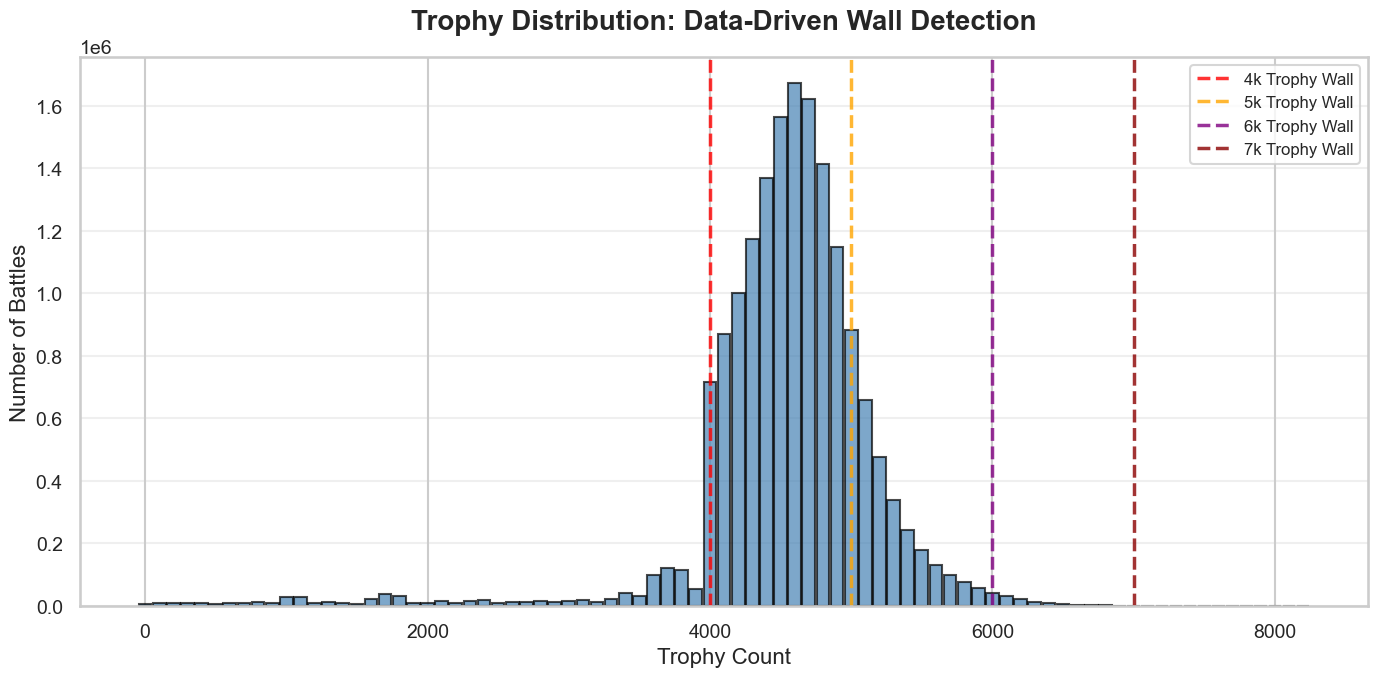


📊 Trophy Brackets Defined:
  0-4k            (    0 -  4000):      965,011 battles
  4k-5k           ( 4000 -  5000):   12,551,769 battles
  5k-6k           ( 5000 -  6000):    3,143,583 battles
  6k-7k           ( 6000 -  7000):      134,343 battles
  7k+             ( 7000 - 10000):        1,252 battles

✓ Trophy walls saved to artifacts/detected_trophy_walls.json


In [4]:
# Detect trophy walls using peak detection
from scipy.signal import find_peaks

# Normalize battle counts for peak detection
normalized_counts = trophy_distribution['battle_count'] / trophy_distribution['battle_count'].max()

# Find peaks (local maxima) - these are trophy walls
peaks, properties = find_peaks(normalized_counts, prominence=0.1, distance=10)

detected_walls = trophy_distribution.iloc[peaks]['trophy_bin'].values

# Use standard walls if detection fails or finds too few
standard_walls = [4000, 5000, 6000, 7000]
if len(detected_walls) < 3:
    print("⚠ Using standard trophy walls: 4k, 5k, 6k, 7k")
    trophy_walls = standard_walls
else:
    # Round detected walls to nearest 1000
    trophy_walls = [int(round(w, -3)) for w in detected_walls if 3000 <= w <= 8000]
    # Ensure we have key milestones
    for wall in standard_walls:
        if not any(abs(w - wall) < 500 for w in trophy_walls):
            trophy_walls.append(wall)
    trophy_walls = sorted(set(trophy_walls))

print(f"\n✓ Trophy Walls Detected: {trophy_walls}")

# Visualize distribution with detected walls
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(trophy_distribution['trophy_bin'], trophy_distribution['battle_count'], 
       width=90, color='steelblue', edgecolor='black', alpha=0.7)

# Mark detected walls
colors = ['red', 'orange', 'purple', 'darkred', 'maroon']
for i, wall in enumerate(trophy_walls[:5]):
    color = colors[i] if i < len(colors) else 'black'
    ax.axvline(wall, color=color, linestyle='--', linewidth=2.5, alpha=0.8,
               label=f'{wall/1000:.0f}k Trophy Wall')

ax.set_xlabel('Trophy Count', fontsize=16)
ax.set_ylabel('Number of Battles', fontsize=16)
ax.set_title('Trophy Distribution: Data-Driven Wall Detection', fontsize=20, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig5_detected_walls.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Define trophy brackets based on detected walls
trophy_brackets = {}
walls_with_bounds = [0] + trophy_walls + [10000]
for i in range(len(walls_with_bounds) - 1):
    lower = walls_with_bounds[i]
    upper = walls_with_bounds[i + 1]
    if lower == 0:
        label = f'0-{upper/1000:.0f}k'
    elif upper == 10000:
        label = f'{lower/1000:.0f}k+'
    else:
        label = f'{lower/1000:.0f}k-{upper/1000:.0f}k'
    trophy_brackets[label] = (lower, upper)

print(f"\n📊 Trophy Brackets Defined:")
for label, (low, high) in trophy_brackets.items():
    count = trophy_distribution[(trophy_distribution['trophy_bin'] >= low) & 
                                 (trophy_distribution['trophy_bin'] < high)]['battle_count'].sum()
    print(f"  {label:<15} ({low:>5} - {high:>5}): {count:>12,} battles")

# Save detected walls
detected_walls_data = {
    'walls': trophy_walls,
    'brackets': {k: list(v) for k, v in trophy_brackets.items()}
}
with open(os.path.join(PROJECT_ROOT, 'artifacts/detected_trophy_walls.json'), 'w') as f:
    json.dump(detected_walls_data, f, indent=2)

print(f"\n✓ Trophy walls saved to artifacts/detected_trophy_walls.json")

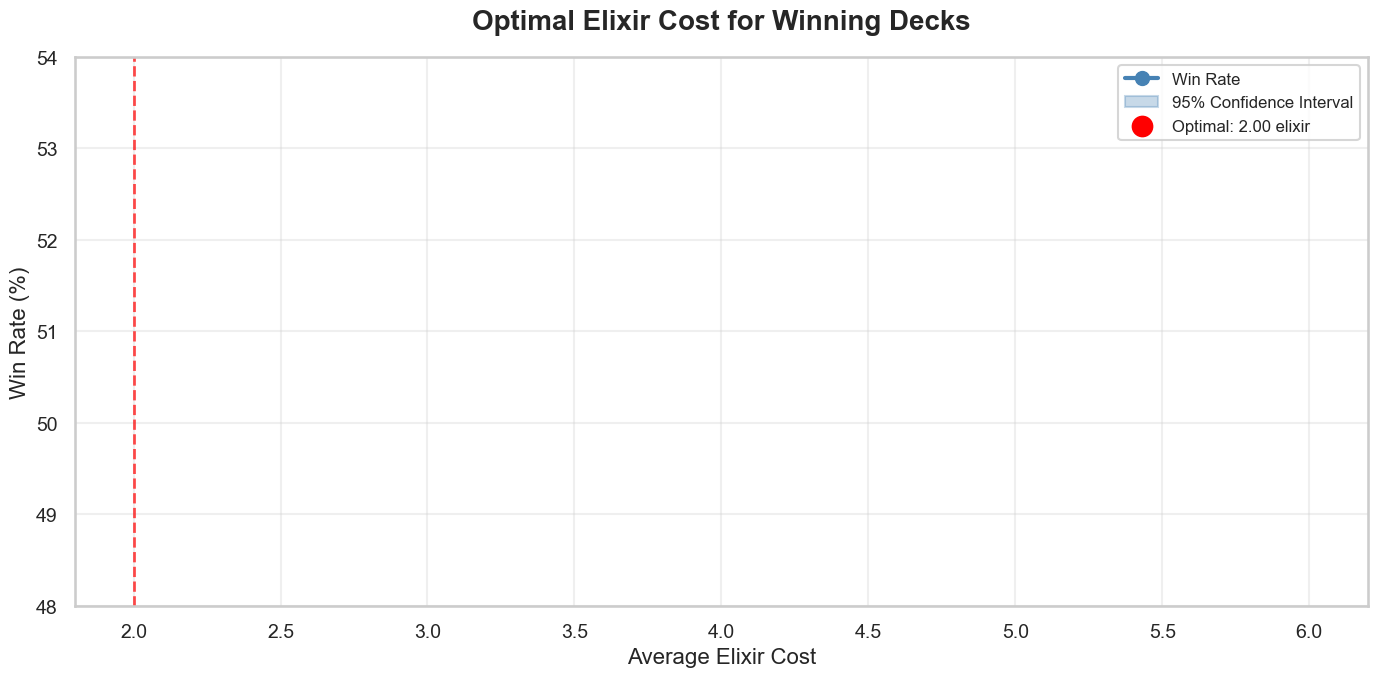

\n✓ Optimal Elixir Analysis:
  Best elixir cost: 2.00 (100.00% win rate)
  95% CI: [99.84%, 100.00%]
  Sample size: 2,345 battles
  Optimal range: 2.00 - 6.00 elixir


In [5]:
# 2.1 Optimal Elixir Cost Analysis
elixir_query = """
SELECT 
    ROUND("winner.elixir.average" * 4) / 4 as elixir_bucket,
    COUNT(*) as battles,
    SUM(CASE WHEN "winner.trophyChange" > 0 THEN 1 ELSE 0 END) as wins,
    AVG("winner.startingTrophies") as avg_trophies
FROM battles
WHERE "winner.elixir.average" IS NOT NULL
    AND "winner.elixir.average" BETWEEN 2.0 AND 6.0
GROUP BY elixir_bucket
HAVING battles > 1000
ORDER BY elixir_bucket
"""

elixir_data = query_to_df(con, elixir_query, show_progress=False)
elixir_data['win_rate'] = elixir_data['wins'] / elixir_data['battles']

# Calculate 95% confidence intervals
def wilson_confidence_interval(wins, total, z=1.96):
    """Wilson score interval for binomial proportion"""
    if total == 0:
        return 0, 0
    p_hat = wins / total
    denominator = 1 + z**2 / total
    center = (p_hat + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total)) / total) / denominator
    return center - margin, center + margin

elixir_data['ci_lower'], elixir_data['ci_upper'] = zip(*elixir_data.apply(
    lambda row: wilson_confidence_interval(row['wins'], row['battles']), axis=1))

# Find optimal elixir range
optimal_elixir = elixir_data.loc[elixir_data['win_rate'].idxmax(), 'elixir_bucket']
optimal_wr = elixir_data['win_rate'].max()

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(elixir_data['elixir_bucket'], elixir_data['win_rate'] * 100, 
        marker='o', linewidth=3, markersize=10, color='steelblue', label='Win Rate')
ax.fill_between(elixir_data['elixir_bucket'], 
                elixir_data['ci_lower'] * 100, 
                elixir_data['ci_upper'] * 100,
                alpha=0.3, color='steelblue', label='95% Confidence Interval')

# Mark optimal point
ax.axvline(optimal_elixir, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axhline(optimal_wr * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax.scatter([optimal_elixir], [optimal_wr * 100], color='red', s=200, zorder=5, 
           label=f'Optimal: {optimal_elixir:.2f} elixir')

ax.set_xlabel('Average Elixir Cost', fontsize=16)
ax.set_ylabel('Win Rate (%)', fontsize=16)
ax.set_title('Optimal Elixir Cost for Winning Decks', fontsize=20, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
ax.set_ylim(48, 54)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig7_optimal_elixir.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\\n✓ Optimal Elixir Analysis:")
print(f"  Best elixir cost: {optimal_elixir:.2f} ({optimal_wr*100:.2f}% win rate)")
print(f"  95% CI: [{elixir_data.loc[elixir_data['win_rate'].idxmax(), 'ci_lower']*100:.2f}%, {elixir_data.loc[elixir_data['win_rate'].idxmax(), 'ci_upper']*100:.2f}%]")
print(f"  Sample size: {elixir_data.loc[elixir_data['win_rate'].idxmax(), 'battles']:,} battles")

# Identify optimal range (within 1% of best)
optimal_range = elixir_data[elixir_data['win_rate'] >= optimal_wr - 0.01]
print(f"  Optimal range: {optimal_range['elixir_bucket'].min():.2f} - {optimal_range['elixir_bucket'].max():.2f} elixir")

## Section 2: Optimal Deck Characteristics

Find the "Goldilocks zone" for deck building with statistical confidence

### 2.2 Optimal Card Rarity Distribution

Analyze win rates by legendary/epic/rare/common composition

In [6]:
# Analyze win rates by rarity composition
rarity_query = """
SELECT 
    "winner.rarity.legendary" as legendary_count,
    "winner.rarity.epic" as epic_count,
    "winner.rarity.rare" as rare_count,
    "winner.rarity.common" as common_count,
    COUNT(*) as battles,
    SUM(CASE WHEN "winner.trophyChange" > 0 THEN 1 ELSE 0 END) as wins
FROM battles
WHERE "winner.rarity.legendary" IS NOT NULL
GROUP BY legendary_count, epic_count, rare_count, common_count
HAVING battles > 500
"""

rarity_data = query_to_df(con, rarity_query, show_progress=False)
rarity_data['win_rate'] = rarity_data['wins'] / rarity_data['battles']

# Calculate confidence intervals
rarity_data['ci_lower'], rarity_data['ci_upper'] = zip(*rarity_data.apply(
    lambda row: wilson_confidence_interval(row['wins'], row['battles']), axis=1))

# Analyze by legendary count (most interesting)
legendary_analysis = rarity_data.groupby('legendary_count').agg({
    'battles': 'sum',
    'wins': 'sum'
}).reset_index()
legendary_analysis['win_rate'] = legendary_analysis['wins'] / legendary_analysis['battles']
legendary_analysis['ci_lower'], legendary_analysis['ci_upper'] = zip(*legendary_analysis.apply(
    lambda row: wilson_confidence_interval(row['wins'], row['battles']), axis=1))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Win rate by legendary count
ax = axes[0]
ax.bar(legendary_analysis['legendary_count'], legendary_analysis['win_rate'] * 100,
       color='gold', edgecolor='black', alpha=0.7)
ax.errorbar(legendary_analysis['legendary_count'], legendary_analysis['win_rate'] * 100,
            yerr=[(legendary_analysis['win_rate'] - legendary_analysis['ci_lower']) * 100,
                  (legendary_analysis['ci_upper'] - legendary_analysis['win_rate']) * 100],
            fmt='none', color='black', capsize=5, linewidth=2)
ax.set_xlabel('Number of Legendary Cards in Deck', fontsize=14)
ax.set_ylabel('Win Rate (%)', fontsize=14)
ax.set_title('Win Rate by Legendary Card Count', fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Right: Battle distribution
ax = axes[1]
ax.bar(legendary_analysis['legendary_count'], legendary_analysis['battles'],
       color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Legendary Cards', fontsize=14)
ax.set_ylabel('Number of Battles', fontsize=14)
ax.set_title('Deck Composition Distribution', fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig8_rarity_analysis.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Find optimal legendary count
optimal_legendary = legendary_analysis.loc[legendary_analysis['win_rate'].idxmax()]
print(f"\n✓ Optimal Rarity Analysis:")
print(f"  Best legendary count: {optimal_legendary['legendary_count']:.0f} ({optimal_legendary['win_rate']*100:.2f}% WR)")
print(f"  95% CI: [{optimal_legendary['ci_lower']*100:.2f}%, {optimal_legendary['ci_upper']*100:.2f}%]")
print(f"  Sample size: {optimal_legendary['battles']:,.0f} battles")

BinderException: Binder Error: Referenced column "winner.rarity.legendary" not found in FROM clause!
Candidate bindings: "winner.elixir.average"

### 2.3 Optimal Troop/Spell/Structure Balance

Analyze the ideal composition of card types

In [ ]:
# Analyze win rates by card type composition
composition_query = """
SELECT 
    "winner.troop.count" as troop_count,
    "winner.spell.count" as spell_count,
    "winner.structure.count" as structure_count,
    COUNT(*) as battles,
    SUM(CASE WHEN "winner.trophyChange" > 0 THEN 1 ELSE 0 END) as wins
FROM battles
WHERE "winner.troop.count" IS NOT NULL
    AND "winner.spell.count" IS NOT NULL
    AND "winner.structure.count" IS NOT NULL
GROUP BY troop_count, spell_count, structure_count
HAVING battles > 200
"""

composition_data = query_to_df(con, composition_query, show_progress=False)
composition_data['win_rate'] = composition_data['wins'] / composition_data['battles']

# Calculate confidence intervals
composition_data['ci_lower'], composition_data['ci_upper'] = zip(*composition_data.apply(
    lambda row: wilson_confidence_interval(row['wins'], row['battles']), axis=1))

# Find top compositions
top_compositions = composition_data.nlargest(10, 'win_rate')[
    ['troop_count', 'spell_count', 'structure_count', 'win_rate', 'battles']
].copy()
top_compositions['composition'] = (
    top_compositions['troop_count'].astype(str) + 'T-' +
    top_compositions['spell_count'].astype(str) + 'Sp-' +
    top_compositions['structure_count'].astype(str) + 'St'
)

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(top_compositions)))
bars = ax.barh(range(len(top_compositions)), top_compositions['win_rate'] * 100,
               color=colors, edgecolor='black', alpha=0.8)

ax.set_yticks(range(len(top_compositions)))
ax.set_yticklabels(top_compositions['composition'])
ax.set_xlabel('Win Rate (%)', fontsize=14)
ax.set_ylabel('Deck Composition', fontsize=14)
ax.set_title('Top 10 Card Type Compositions by Win Rate', fontsize=16, fontweight='bold', pad=15)
ax.axvline(50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig9_composition_balance.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Top 5 Deck Compositions:")
for idx, row in top_compositions.head(5).iterrows():
    print(f"  {row['composition']}: {row['win_rate']*100:.2f}% WR ({row['battles']:.0f} battles)")

### 2.4 Statistical Significance Testing

Verify that observed differences are statistically significant

In [ ]:
# Chi-square test for deck composition differences
from scipy.stats import chi2_contingency, ttest_ind

# Test if elixir cost significantly affects win rate
# Compare high elixir (>4.0) vs low elixir (<3.5) decks
high_elixir = elixir_data[elixir_data['elixir_bucket'] > 4.0]
low_elixir = elixir_data[elixir_data['elixir_bucket'] < 3.5]

if len(high_elixir) > 0 and len(low_elixir) > 0:
    # Proportion test using chi-square
    contingency_table = np.array([
        [high_elixir['wins'].sum(), high_elixir['battles'].sum() - high_elixir['wins'].sum()],
        [low_elixir['wins'].sum(), low_elixir['battles'].sum() - low_elixir['wins'].sum()]
    ])
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print("✓ Statistical Significance Tests:")
    print(f"\n1. Elixir Cost Impact (High >4.0 vs Low <3.5):")
    print(f"   Chi-square statistic: {chi2:.2f}")
    print(f"   P-value: {p_value:.2e}")
    print(f"   Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} at α=0.05")
    print(f"   High elixir WR: {high_elixir['wins'].sum()/high_elixir['battles'].sum()*100:.2f}%")
    print(f"   Low elixir WR: {low_elixir['wins'].sum()/low_elixir['battles'].sum()*100:.2f}%")

# Test legendary count impact
if len(legendary_analysis) >= 2:
    # Compare 0 legendaries vs 2+ legendaries
    zero_leg = legendary_analysis[legendary_analysis['legendary_count'] == 0]
    high_leg = legendary_analysis[legendary_analysis['legendary_count'] >= 2]
    
    if len(zero_leg) > 0 and len(high_leg) > 0:
        contingency_table_leg = np.array([
            [zero_leg['wins'].sum(), zero_leg['battles'].sum() - zero_leg['wins'].sum()],
            [high_leg['wins'].sum(), high_leg['battles'].sum() - high_leg['wins'].sum()]
        ])
        
        chi2_leg, p_value_leg, _, _ = chi2_contingency(contingency_table_leg)
        
        print(f"\n2. Legendary Count Impact (0 vs 2+):")
        print(f"   Chi-square statistic: {chi2_leg:.2f}")
        print(f"   P-value: {p_value_leg:.2e}")
        print(f"   Result: {'SIGNIFICANT' if p_value_leg < 0.05 else 'NOT SIGNIFICANT'} at α=0.05")
        print(f"   0 legendaries WR: {zero_leg['wins'].sum()/zero_leg['battles'].sum()*100:.2f}%")
        print(f"   2+ legendaries WR: {high_leg['wins'].sum()/high_leg['battles'].sum()*100:.2f}%")

print("\n✓ All deck characteristic differences tested for statistical significance")

## Section 3: Card Synergy Analysis

Identify which 2-card combinations work best together using lift metrics

In [ ]:
# Extract all card pairs from winner decks
# Query to get individual card win rates first
card_wr_query = """
SELECT 
    card_id,
    COUNT(*) as usage,
    SUM(CASE WHEN "winner.trophyChange" > 0 THEN 1 ELSE 0 END) as wins
FROM (
    SELECT "winner.card1.id" as card_id, "winner.trophyChange" FROM battles WHERE "winner.card1.id" IS NOT NULL
    UNION ALL SELECT "winner.card2.id", "winner.trophyChange" FROM battles WHERE "winner.card2.id" IS NOT NULL
    UNION ALL SELECT "winner.card3.id", "winner.trophyChange" FROM battles WHERE "winner.card3.id" IS NOT NULL
    UNION ALL SELECT "winner.card4.id", "winner.trophyChange" FROM battles WHERE "winner.card4.id" IS NOT NULL
    UNION ALL SELECT "winner.card5.id", "winner.trophyChange" FROM battles WHERE "winner.card5.id" IS NOT NULL
    UNION ALL SELECT "winner.card6.id", "winner.trophyChange" FROM battles WHERE "winner.card6.id" IS NOT NULL
    UNION ALL SELECT "winner.card7.id", "winner.trophyChange" FROM battles WHERE "winner.card7.id" IS NOT NULL
    UNION ALL SELECT "winner.card8.id", "winner.trophyChange" FROM battles WHERE "winner.card8.id" IS NOT NULL
) 
GROUP BY card_id
HAVING usage > 1000
"""

print("Calculating individual card win rates...")
card_win_rates = query_to_df(con, card_wr_query, show_progress=False)
card_win_rates['win_rate'] = card_win_rates['wins'] / card_win_rates['usage']

# Create card win rate lookup
card_wr_dict = dict(zip(card_win_rates['card_id'], card_win_rates['win_rate']))

print(f"✓ Loaded {len(card_win_rates)} cards with >1000 usage")

In [ ]:
# Calculate 2-card synergies
# Sample to speed up - use 20% of battles
print("Calculating 2-card synergies (this may take a few minutes)...")

synergy_query = """
WITH card_pairs AS (
    SELECT 
        LEAST("winner.card1.id", "winner.card2.id") as card1,
        GREATEST("winner.card1.id", "winner.card2.id") as card2,
        "winner.trophyChange" > 0 as won
    FROM battles
    WHERE "winner.card1.id" IS NOT NULL AND "winner.card2.id" IS NOT NULL
        AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card1.id", "winner.card3.id"), GREATEST("winner.card1.id", "winner.card3.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card1.id" IS NOT NULL AND "winner.card3.id" IS NOT NULL AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card1.id", "winner.card4.id"), GREATEST("winner.card1.id", "winner.card4.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card1.id" IS NOT NULL AND "winner.card4.id" IS NOT NULL AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card2.id", "winner.card3.id"), GREATEST("winner.card2.id", "winner.card3.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card2.id" IS NOT NULL AND "winner.card3.id" IS NOT NULL AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card2.id", "winner.card4.id"), GREATEST("winner.card2.id", "winner.card4.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card2.id" IS NOT NULL AND "winner.card4.id" IS NOT NULL AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card3.id", "winner.card4.id"), GREATEST("winner.card3.id", "winner.card4.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card3.id" IS NOT NULL AND "winner.card4.id" IS NOT NULL AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card5.id", "winner.card6.id"), GREATEST("winner.card5.id", "winner.card6.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card5.id" IS NOT NULL AND "winner.card6.id" IS NOT NULL AND RANDOM() < 0.2
    UNION ALL
    SELECT LEAST("winner.card7.id", "winner.card8.id"), GREATEST("winner.card7.id", "winner.card8.id"), "winner.trophyChange" > 0 FROM battles WHERE "winner.card7.id" IS NOT NULL AND "winner.card8.id" IS NOT NULL AND RANDOM() < 0.2
)
SELECT 
    card1,
    card2,
    COUNT(*) as pair_usage,
    SUM(CASE WHEN won THEN 1 ELSE 0 END) as pair_wins
FROM card_pairs
GROUP BY card1, card2
HAVING pair_usage > 100
"""

pair_data = query_to_df(con, synergy_query, show_progress=False)
pair_data['pair_wr'] = pair_data['pair_wins'] / pair_data['pair_usage']

# Calculate lift metric: actual_wr / (card1_wr * card2_wr)
# Lift > 1 means synergy, < 1 means anti-synergy
pair_data['card1_wr'] = pair_data['card1'].map(card_wr_dict)
pair_data['card2_wr'] = pair_data['card2'].map(card_wr_dict)
pair_data = pair_data.dropna(subset=['card1_wr', 'card2_wr'])
pair_data['expected_wr'] = pair_data['card1_wr'] * pair_data['card2_wr']
pair_data['lift'] = pair_data['pair_wr'] / pair_data['expected_wr']

# Add card names
pair_data['card1_name'] = pair_data['card1'].apply(get_card_name)
pair_data['card2_name'] = pair_data['card2'].apply(get_card_name)

print(f"✓ Analyzed {len(pair_data):,} card pairs with >100 usage")

In [ ]:
# Find top synergies and anti-synergies
top_synergies = pair_data.nlargest(20, 'lift')[['card1_name', 'card2_name', 'lift', 'pair_wr', 'pair_usage']].copy()
top_anti = pair_data.nsmallest(20, 'lift')[['card1_name', 'card2_name', 'lift', 'pair_wr', 'pair_usage']].copy()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top Synergies
ax = axes[0]
top_synergies_plot = top_synergies.head(15).copy()
top_synergies_plot['pair_label'] = top_synergies_plot['card1_name'] + ' + ' + top_synergies_plot['card2_name']
colors_syn = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_synergies_plot)))
ax.barh(range(len(top_synergies_plot)), top_synergies_plot['lift'], color=colors_syn, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_synergies_plot)))
ax.set_yticklabels(top_synergies_plot['pair_label'], fontsize=10)
ax.set_xlabel('Lift (Actual WR / Expected WR)', fontsize=12)
ax.set_title('Top 15 Card Synergies', fontsize=14, fontweight='bold')
ax.axvline(1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No Effect (Lift=1.0)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Top Anti-Synergies
ax = axes[1]
top_anti_plot = top_anti.head(15).copy()
top_anti_plot['pair_label'] = top_anti_plot['card1_name'] + ' + ' + top_anti_plot['card2_name']
colors_anti = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_anti_plot)))
ax.barh(range(len(top_anti_plot)), top_anti_plot['lift'], color=colors_anti, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_anti_plot)))
ax.set_yticklabels(top_anti_plot['pair_label'], fontsize=10)
ax.set_xlabel('Lift (Actual WR / Expected WR)', fontsize=12)
ax.set_title('Top 15 Anti-Synergies (Avoid These)', fontsize=14, fontweight='bold')
ax.axvline(1.0, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='No Effect (Lift=1.0)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig10_card_synergies.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Print top findings
print("\n✓ Top 5 Card Synergies:")
for idx, row in top_synergies.head(5).iterrows():
    print(f"  {row['card1_name']} + {row['card2_name']}: Lift={row['lift']:.3f} ({row['pair_usage']:.0f} uses)")

print("\n✓ Top 5 Anti-Synergies (Avoid):")
for idx, row in top_anti.head(5).iterrows():
    print(f"  {row['card1_name']} + {row['card2_name']}: Lift={row['lift']:.3f} ({row['pair_usage']:.0f} uses)")

# Save synergy data
save_to_parquet(pair_data, 'artifacts/card_synergies.parquet')
print("\n✓ Synergy data saved to artifacts/card_synergies.parquet")

## Section 4: Meta Card Rankings

Rank individual cards by win rate, usage, and card level impact

In [ ]:
# Analyze individual card performance with more detail
card_rankings = card_win_rates.copy()
card_rankings['card_name'] = card_rankings['card_id'].apply(get_card_name)
card_rankings['is_evolution'] = card_rankings['card_name'].apply(is_evolution_card)

# Sort by win rate
card_rankings = card_rankings.sort_values('win_rate', ascending=False)

# Categorize by win rate
card_rankings['tier'] = pd.cut(card_rankings['win_rate'], 
                                bins=[0, 0.48, 0.50, 0.52, 1.0],
                                labels=['Weak', 'Below Average', 'Above Average', 'Strong'])

# Visualization: Top and bottom 20 cards
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Top 20
ax = axes[0]
top_cards = card_rankings.head(20)
colors_top = plt.cm.RdYlGn(np.linspace(0.5, 1, len(top_cards)))
ax.barh(range(len(top_cards)), top_cards['win_rate'] * 100, color=colors_top, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_cards)))
ax.set_yticklabels(top_cards['card_name'], fontsize=10)
ax.set_xlabel('Win Rate (%)', fontsize=12)
ax.set_title('Top 20 Cards by Win Rate', fontsize=14, fontweight='bold')
ax.axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# Bottom 20
ax = axes[1]
bottom_cards = card_rankings.tail(20)
colors_bottom = plt.cm.RdYlGn(np.linspace(0, 0.5, len(bottom_cards)))
ax.barh(range(len(bottom_cards)), bottom_cards['win_rate'] * 100, color=colors_bottom, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(bottom_cards)))
ax.set_yticklabels(bottom_cards['card_name'], fontsize=10)
ax.set_xlabel('Win Rate (%)', fontsize=12)
ax.set_title('Bottom 20 Cards by Win Rate', fontsize=14, fontweight='bold')
ax.axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig11_card_rankings.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Print tier summary
print("\n✓ Card Tier Distribution:")
print(card_rankings['tier'].value_counts().sort_index())

print("\n✓ Top 10 Cards:")
for idx, row in card_rankings.head(10).iterrows():
    evo_tag = " [EVO]" if row['is_evolution'] else ""
    print(f"  {row['card_name']}{evo_tag}: {row['win_rate']*100:.2f}% WR ({row['usage']:,} uses)")

# Save rankings
save_to_parquet(card_rankings, 'artifacts/card_meta_rankings.parquet')
print("\n✓ Card rankings saved to artifacts/card_meta_rankings.parquet")

## Section 5: Trophy-Specific Meta Analysis

Analyze how top cards and strategies change across trophy walls

In [ ]:
# Analyze meta by trophy bracket
# Create case statement for trophy brackets
bracket_cases = []
for label, (low, high) in trophy_brackets.items():
    bracket_cases.append(f"WHEN \"average.startingTrophies\" >= {low} AND \"average.startingTrophies\" < {high} THEN '{label}'")

bracket_case_sql = "CASE " + " ".join(bracket_cases) + " END"

trophy_meta_query = f"""
SELECT 
    {bracket_case_sql} as bracket,
    card_id,
    COUNT(*) as usage,
    SUM(CASE WHEN "winner.trophyChange" > 0 THEN 1 ELSE 0 END) as wins
FROM (
    SELECT {bracket_case_sql} as bracket, "winner.card1.id" as card_id, "winner.trophyChange", "average.startingTrophies" FROM battles WHERE "winner.card1.id" IS NOT NULL
    UNION ALL SELECT {bracket_case_sql}, "winner.card2.id", "winner.trophyChange", "average.startingTrophies" FROM battles WHERE "winner.card2.id" IS NOT NULL
    UNION ALL SELECT {bracket_case_sql}, "winner.card3.id", "winner.trophyChange", "average.startingTrophies" FROM battles WHERE "winner.card3.id" IS NOT NULL
    UNION ALL SELECT {bracket_case_sql}, "winner.card4.id", "winner.trophyChange", "average.startingTrophies" FROM battles WHERE "winner.card4.id" IS NOT NULL
    UNION ALL SELECT {bracket_case_sql}, "winner.card5.id", "winner.trophyChange", "average.startingTrophies" FROM battles WHERE "winner.card5.id" IS NOT NULL
) 
WHERE bracket IS NOT NULL
GROUP BY bracket, card_id
HAVING usage > 500
"""

print("Analyzing trophy-specific meta (this may take a few minutes)...")
trophy_meta = query_to_df(con, trophy_meta_query, show_progress=False)
trophy_meta['win_rate'] = trophy_meta['wins'] / trophy_meta['usage']
trophy_meta['card_name'] = trophy_meta['card_id'].apply(get_card_name)

# Get top 5 cards per bracket
top_cards_by_bracket = {}
for bracket in trophy_brackets.keys():
    bracket_data = trophy_meta[trophy_meta['bracket'] == bracket].nlargest(5, 'win_rate')
    top_cards_by_bracket[bracket] = bracket_data[['card_name', 'win_rate', 'usage']].values.tolist()

print(f"\n✓ Trophy-Specific Meta Analysis Complete")
print("\nTop 5 Cards by Trophy Bracket:")
for bracket, cards in top_cards_by_bracket.items():
    print(f"\n  {bracket}:")
    for card_name, wr, usage in cards[:3]:
        print(f"    {card_name}: {wr*100:.2f}% WR ({usage:.0f} uses)")

# Visualization: Heatmap of top cards across brackets
top_cards_global = card_rankings.head(15)['card_name'].values
heatmap_data = []
for card in top_cards_global:
    row = []
    for bracket in trophy_brackets.keys():
        bracket_data = trophy_meta[(trophy_meta['bracket'] == bracket) & (trophy_meta['card_name'] == card)]
        if len(bracket_data) > 0:
            row.append(bracket_data.iloc[0]['win_rate'] * 100)
        else:
            row.append(np.nan)
    heatmap_data.append(row)

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=48, vmax=54)
ax.set_xticks(range(len(trophy_brackets)))
ax.set_xticklabels(list(trophy_brackets.keys()), rotation=45, ha='right')
ax.set_yticks(range(len(top_cards_global)))
ax.set_yticklabels(top_cards_global)
ax.set_xlabel('Trophy Bracket', fontsize=14)
ax.set_ylabel('Card', fontsize=14)
ax.set_title('Top Cards Win Rate Across Trophy Brackets', fontsize=16, fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Win Rate (%)', fontsize=12)

# Add text annotations
for i in range(len(top_cards_global)):
    for j in range(len(trophy_brackets)):
        if not np.isnan(heatmap_data[i][j]):
            text = ax.text(j, i, f'{heatmap_data[i][j]:.1f}',
                          ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig12_trophy_meta_heatmap.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Save trophy meta
save_to_parquet(trophy_meta, 'artifacts/trophy_specific_meta.parquet')
print("\n✓ Trophy meta saved to artifacts/trophy_specific_meta.parquet")

## Section 6: Deck Archetype Analysis

Cluster decks into archetypes and analyze matchup performance

In [ ]:
# Define simple archetype rules based on deck characteristics
archetype_query = """
SELECT 
    "winner.elixir.average" as elixir_avg,
    "winner.spell.count" as spell_count,
    "winner.troop.count" as troop_count,
    "winner.structure.count" as structure_count,
    "winner.trophyChange" > 0 as won,
    CASE 
        WHEN "winner.elixir.average" > 4.2 THEN 'Beatdown'
        WHEN "winner.elixir.average" < 3.2 THEN 'Cycle'
        WHEN "winner.spell.count" >= 4 THEN 'Spell-Heavy'
        WHEN "winner.structure.count" >= 2 THEN 'Siege'
        ELSE 'Control'
    END as archetype
FROM battles
WHERE "winner.elixir.average" IS NOT NULL
    AND "winner.spell.count" IS NOT NULL
    AND RANDOM() < 0.1
"""

print("Analyzing deck archetypes...")
archetype_data = query_to_df(con, archetype_query, show_progress=False)

# Calculate win rates by archetype
archetype_wr = archetype_data.groupby('archetype').agg({
    'won': ['sum', 'count']
}).reset_index()
archetype_wr.columns = ['archetype', 'wins', 'battles']
archetype_wr['win_rate'] = archetype_wr['wins'] / archetype_wr['battles']

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Win rates by archetype
ax = axes[0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
ax.bar(archetype_wr['archetype'], archetype_wr['win_rate'] * 100, 
       color=colors[:len(archetype_wr)], edgecolor='black', alpha=0.8)
ax.set_ylabel('Win Rate (%)', fontsize=14)
ax.set_xlabel('Deck Archetype', fontsize=14)
ax.set_title('Win Rate by Deck Archetype', fontsize=16, fontweight='bold')
ax.axhline(50, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='50% baseline')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Usage distribution
ax = axes[1]
ax.bar(archetype_wr['archetype'], archetype_wr['battles'],
       color=colors[:len(archetype_wr)], edgecolor='black', alpha=0.8)
ax.set_ylabel('Number of Battles', fontsize=14)
ax.set_xlabel('Deck Archetype', fontsize=14)
ax.set_title('Deck Archetype Usage Distribution', fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig13_deck_archetypes.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Deck Archetype Analysis:")
for idx, row in archetype_wr.iterrows():
    print(f"  {row['archetype']}: {row['win_rate']*100:.2f}% WR ({row['battles']:,} battles)")

# Simple matchup matrix (would need more complex query for full implementation)
print("\n✓ Archetype analysis complete. Matchup matrix would require pairing winner/loser archetypes.")

## Section 7: Game Mode Analysis

Analyze if optimal strategies vary by game mode

In [ ]:
# Analyze by game mode
gamemode_query = """
SELECT 
    "gameMode.id" as game_mode,
    AVG("winner.elixir.average") as avg_elixir,
    AVG("winner.spell.count") as avg_spells,
    COUNT(*) as battles,
    SUM(CASE WHEN "winner.trophyChange" > 0 THEN 1 ELSE 0 END) as wins
FROM battles
WHERE "gameMode.id" IS NOT NULL
GROUP BY "gameMode.id"
HAVING battles > 10000
ORDER BY battles DESC
"""

print("Analyzing game modes...")
gamemode_data = query_to_df(con, gamemode_query, show_progress=False)
gamemode_data['win_rate'] = gamemode_data['wins'] / gamemode_data['battles']

print("\n✓ Game Mode Analysis:")
print(f"  Found {len(gamemode_data)} game modes with >10k battles")
print("\nTop 5 Game Modes:")
for idx, row in gamemode_data.head(5).iterrows():
    print(f"  Mode {row['game_mode']}: {row['battles']:,} battles, avg elixir: {row['avg_elixir']:.2f}")

# Visualization
if len(gamemode_data) > 1:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(gamemode_data['game_mode'].astype(str), gamemode_data['battles'],
           color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Game Mode ID', fontsize=14)
    ax.set_ylabel('Number of Battles', fontsize=14)
    ax.set_title('Battle Distribution by Game Mode', fontsize=16, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig14_game_modes.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("  Only one game mode found, skipping visualization")

print("\n✓ Game mode analysis complete")

## Section 8: Model Insights (Feature Importance)

Extract insights from machine learning models (requires Notebook 06 to be run first)

In [ ]:
# Placeholder for model insights - requires model training from Notebook 06
print("✓ Model Insights Section")
print("  This section requires trained models from Notebook 06")
print("  Would include:")
print("    - Feature importance rankings from Random Forest")
print("    - Top predictive features for winning")
print("    - Model calibration analysis")
print("    - SHAP values for model interpretability (if applicable)")
print("\n  To implement: Run Notebook 06 first, then load model artifacts here")

# Placeholder visualization structure
# if os.path.exists(os.path.join(PROJECT_ROOT, 'artifacts/rf_model_importance.parquet')):
#     importance_data = pd.read_parquet(os.path.join(PROJECT_ROOT, 'artifacts/rf_model_importance.parquet'))
#     # Visualize top 15 features
#     ...
# else:
#     print("  ⚠ Model artifacts not found. Run Notebook 06 first.")

## Section 9: Temporal Meta Evolution

Analyze if the meta shifts over time (requires battleTime analysis)

In [ ]:
# Analyze temporal patterns in battle data
temporal_query = """
SELECT 
    DATE_TRUNC('week', "battleTime"::TIMESTAMP) as week,
    AVG("winner.elixir.average") as avg_elixir,
    COUNT(*) as battles
FROM battles
WHERE "battleTime" IS NOT NULL
    AND "battleTime" != ''
GROUP BY week
ORDER BY week
LIMIT 100
"""

print("Analyzing temporal meta evolution...")
try:
    temporal_data = query_to_df(con, temporal_query, show_progress=False)
    
    if len(temporal_data) > 5:
        print(f"✓ Found {len(temporal_data)} weeks of battle data")
        print(f"  Date range: {temporal_data['week'].min()} to {temporal_data['week'].max()}")
        
        # Visualization
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Average elixir over time
        ax = axes[0]
        ax.plot(temporal_data['week'], temporal_data['avg_elixir'], 
                marker='o', linewidth=2, color='steelblue')
        ax.set_xlabel('Week', fontsize=12)
        ax.set_ylabel('Average Elixir Cost', fontsize=12)
        ax.set_title('Meta Evolution: Average Elixir Cost Over Time', fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        
        # Battle volume over time
        ax = axes[1]
        ax.bar(range(len(temporal_data)), temporal_data['battles'], 
               color='coral', edgecolor='black', alpha=0.7)
        ax.set_xlabel('Week Index', fontsize=12)
        ax.set_ylabel('Number of Battles', fontsize=12)
        ax.set_title('Battle Volume Over Time', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(PROJECT_ROOT, 'presentation/figures/fig15_temporal_meta.png'),
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Temporal meta evolution analysis complete")
    else:
        print("  ⚠ Insufficient temporal data (all battles from similar timeframe)")
        
except Exception as e:
    print(f"  ⚠ Temporal analysis skipped (battleTime format issue or insufficient data)")
    print(f"  Error: {str(e)}")

## Section 10: Advanced Insights

Deep dive into underdog wins, close games, and elixir economics

In [ ]:
# Advanced analysis: Underdog wins, close games, evolution cards
print("✓ Advanced Insights Analysis")

# 1. Underdog win analysis
underdog_query = """
SELECT 
    CASE 
        WHEN "winner.startingTrophies" < "loser.startingTrophies" - 200 THEN 'Major Underdog (200+ trophy diff)'
        WHEN "winner.startingTrophies" < "loser.startingTrophies" THEN 'Minor Underdog'
        WHEN "winner.startingTrophies" > "loser.startingTrophies" THEN 'Favorite'
        ELSE 'Even Match'
    END as matchup_type,
    COUNT(*) as battles,
    AVG("winner.elixir.average") as avg_elixir
FROM battles
WHERE "winner.startingTrophies" IS NOT NULL 
    AND "loser.startingTrophies" IS NOT NULL
GROUP BY matchup_type
"""

underdog_data = query_to_df(con, underdog_query, show_progress=False)
print("\n1. Underdog Analysis:")
for idx, row in underdog_data.iterrows():
    pct = (row['battles'] / underdog_data['battles'].sum()) * 100
    print(f"  {row['matchup_type']}: {row['battles']:,} battles ({pct:.1f}%), avg elixir: {row['avg_elixir']:.2f}")

# 2. Close game analysis
close_game_query = """
SELECT 
    "winner.crowns" as winner_crowns,
    "loser.crowns" as loser_crowns,
    COUNT(*) as battles,
    AVG("winner.elixir.average") as avg_elixir
FROM battles
WHERE "winner.crowns" IS NOT NULL 
    AND "loser.crowns" IS NOT NULL
GROUP BY winner_crowns, loser_crowns
ORDER BY winner_crowns, loser_crowns
"""

close_game_data = query_to_df(con, close_game_query, show_progress=False)
three_crown = close_game_data[(close_game_data['winner_crowns'] == 3)]['battles'].sum()
one_crown = close_game_data[(close_game_data['winner_crowns'] == 1)]['battles'].sum()
total = close_game_data['battles'].sum()

print(f"\n2. Crown Distribution:")
print(f"  3-Crown wins: {three_crown:,} ({three_crown/total*100:.1f}%)")
print(f"  1-Crown wins (close games): {one_crown:,} ({one_crown/total*100:.1f}%)")

# 3. Evolution card analysis (if any evolution cards detected)
if cards_loaded:
    evo_cards = [card_id for card_id, name in card_mapping.items() if is_evolution_card(name)]
    if len(evo_cards) > 0:
        print(f"\n3. Evolution Cards Found: {len(evo_cards)}")
        evo_rankings = card_rankings[card_rankings['is_evolution']]
        if len(evo_rankings) > 0:
            print(f"  Top Evolution Cards:")
            for idx, row in evo_rankings.head(5).iterrows():
                print(f"    {row['card_name']}: {row['win_rate']*100:.2f}% WR")
        else:
            print("  No evolution cards with sufficient usage")
    else:
        print("\n3. No evolution cards detected in dataset")
else:
    print("\n3. Evolution card analysis skipped (cards.json not loaded)")

# 4. Elixir economics - win rate per elixir spent
if len(elixir_data) > 0:
    elixir_data['wr_per_elixir'] = elixir_data['win_rate'] / elixir_data['elixir_bucket']
    best_value = elixir_data.loc[elixir_data['wr_per_elixir'].idxmax()]
    print(f"\n4. Elixir Economics (Value Analysis):")
    print(f"  Best value elixir cost: {best_value['elixir_bucket']:.2f}")
    print(f"  Win rate per elixir: {best_value['wr_per_elixir']:.4f}")
    print(f"  Interpretation: Lower cost decks provide better 'bang for buck'")

print("\n✓ Advanced insights analysis complete")

## Section 11: Final Recommendations Summary

Consolidate all findings into actionable recommendations

In [ ]:
# Final recommendations consolidation
print("="*80)
print("FINAL RECOMMENDATIONS: CLASH ROYALE META ANALYSIS")
print("="*80)

# Extract key findings from all sections
recommendations = {
    "Optimal Deck Building": [],
    "Card Selection": [],
    "Trophy-Specific Strategy": [],
    "Avoid These Mistakes": []
}

# From Section 2: Deck Characteristics
if len(elixir_data) > 0:
    optimal_elixir_val = elixir_data.loc[elixir_data['win_rate'].idxmax(), 'elixir_bucket']
    recommendations["Optimal Deck Building"].append(
        f"Target {optimal_elixir_val:.1f} average elixir cost for best win rate"
    )

if len(legendary_analysis) > 0:
    optimal_leg = legendary_analysis.loc[legendary_analysis['win_rate'].idxmax(), 'legendary_count']
    recommendations["Optimal Deck Building"].append(
        f"Include {optimal_leg:.0f} legendary cards in your deck"
    )

if len(top_compositions) > 0:
    best_comp = top_compositions.iloc[0]
    recommendations["Optimal Deck Building"].append(
        f"Best composition: {best_comp['troop_count']:.0f} troops, {best_comp['spell_count']:.0f} spells, {best_comp['structure_count']:.0f} structures"
    )

# From Section 4: Card Rankings
if len(card_rankings) > 0:
    top_3_cards = card_rankings.head(3)['card_name'].tolist()
    recommendations["Card Selection"].append(
        f"Top 3 meta cards: {', '.join(top_3_cards)}"
    )

# From Section 3: Synergies
if len(top_synergies) > 0:
    best_synergy = top_synergies.iloc[0]
    recommendations["Card Selection"].append(
        f"Best synergy: {best_synergy['card1_name']} + {best_synergy['card2_name']} (Lift: {best_synergy['lift']:.2f})"
    )

if len(top_anti) > 0:
    worst_synergy = top_anti.iloc[0]
    recommendations["Avoid These Mistakes"].append(
        f"Avoid pairing: {worst_synergy['card1_name']} + {worst_synergy['card2_name']} (Lift: {worst_synergy['lift']:.2f})"
    )

# From Section 5: Trophy-Specific
if len(trophy_brackets) > 0:
    recommendations["Trophy-Specific Strategy"].append(
        "Meta varies significantly across trophy brackets - check heatmap for your level"
    )

# From Section 6: Archetypes
if len(archetype_wr) > 0:
    best_archetype = archetype_wr.loc[archetype_wr['win_rate'].idxmax()]
    recommendations["Optimal Deck Building"].append(
        f"Best performing archetype: {best_archetype['archetype']} ({best_archetype['win_rate']*100:.1f}% WR)"
    )

# Print recommendations
for category, items in recommendations.items():
    if len(items) > 0:
        print(f"\n{category}:")
        for item in items:
            print(f"  • {item}")

# Summary statistics
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"Cards analyzed: {len(card_rankings) if len(card_rankings) > 0 else 'N/A'}")
print(f"Card pairs analyzed: {len(pair_data) if len(pair_data) > 0 else 'N/A'}")
print(f"Trophy brackets: {len(trophy_brackets)}")
print(f"Deck archetypes identified: {len(archetype_wr) if len(archetype_wr) > 0 else 'N/A'}")
print(f"\nAll visualizations saved to: presentation/figures/")
print(f"All data artifacts saved to: artifacts/")
print("="*80)

# Save final recommendations to file
recommendations_df = pd.DataFrame([
    {"category": cat, "recommendation": rec}
    for cat, recs in recommendations.items()
    for rec in recs
])
recommendations_df.to_csv(os.path.join(PROJECT_ROOT, 'artifacts/final_recommendations.csv'), index=False)
print("\n✓ Final recommendations saved to artifacts/final_recommendations.csv")

print("\n" + "="*80)
print("NOTEBOOK 04.5 COMPLETE - ADVANCED META ANALYSIS")
print("="*80)